Animation showing depth of 1023.3 through various wind events. Wind events and vtaus are described in cells below. 

In [1]:
import numpy as np
import netCDF4 as nc
import matplotlib.pyplot as plt
from salishsea_tools import (nc_tools, viz_tools, gsw_calls)
import numpy.ma as ma
from matplotlib import animation, rc
%matplotlib inline

In [2]:
rc('animation', html='html5')

In [8]:
mesh_mask = nc.Dataset('/home/vdo/MEOPAR/NEMO-forcing/grid/mesh_mask201702.nc')
new_domain = mesh_mask.variables['tmask'][0,:,334:898,114:398]   
def calc_rho(Sal, TempC, P):
    sqrSal = np.sqrt(Sal)
    R1 = ((((6.536332e-9 * TempC - 1.120083e-6) * TempC + 1.001685e-4)
           * TempC - 9.095290e-3) * TempC + 6.793952e-2) * TempC - 28.263737
    R2 = (((5.3875e-9 * TempC - 8.2467e-7) * TempC + 7.6438e-5)
          * TempC - 4.0899e-3) * TempC + 8.24493e-1
    R3 = (-1.6546e-6 * TempC + 1.0227e-4) * TempC - 5.72466e-3
    SIG = (4.8314e-4 * Sal + R3 * sqrSal + R2) * Sal + R1
    V350P = 1.0 / 1028.1063
    SVA   = -SIG * V350P / (1028.1063 + SIG)
    rho = 28.106331 - SVA / (V350P * (V350P + SVA)) + 1000
    return rho
def animate_one_density(file1,file2, rho):
    depth = file1.variables['deptht'][:]
    saline1 = file1.variables['vosaline'][:]
    temp1 = file1.variables['votemper'][:]
    saline2 = file1.variables['vosaline'][:]
    temp2 = file1.variables['votemper'][:]
    a = np.expand_dims(depth, 1).T
    b = np.expand_dims(np.expand_dims(a,2), 3)
    c = np.ones((155,40,564, 284)) * b
    density1 = calc_rho(saline1, temp1, c)
    index1 = (np.abs(density1 - rho)).argmin(axis=1)
    density2 = calc_rho(saline2, temp2, c)
    index2 = (np.abs(density2 - rho)).argmin(axis=1)
    list_of_depths1 = np.zeros((155,564,284))
    for t in range(155):
        for y in range(564):
            for x in range(284):
                list_of_depths1[t,y,x] = depth[index1[t,y,x]]
    list_of_depths2 = np.zeros((155,564,284))
    for t in range(155):
        for y in range(564):
            for x in range(284):
                list_of_depths2[t,y,x] = depth[index2[t,y,x]]
    mask_land = 1 - new_domain[0,:,:]
    fig,ax = plt.subplots(1,2,figsize=(8,8))
    def animate30(i):
        ax[0].clear()
        masked_depths1 = ma.masked_array(list_of_depths1[i,:,:], mask = mask_land)
        ax[0].contourf(masked_depths1, 
                      levels = np.linspace(0, 70, 8))
        ax[0].set_title('hour = %03d'%(i)) 
        ax[1].clear()
        masked_depths2 = ma.masked_array(list_of_depths2[i,:,:], mask = mask_land)
        ax[1].contourf(masked_depths2, 
                      levels = np.linspace(0, 70, 8))
        ax[1].set_title('hour = %03d'%(i)) 
        return ax

    interval = 0.25#in seconds
    ani40 = animation.FuncAnimation(fig,animate30,frames=155,interval=interval*1e+3, repeat=False)
    return ani40

In [9]:
NU0 =nc.Dataset('/ocean/vdo/MEOPAR/completed-runs/SalishSeaLake/NU0/SalishSea_1h_20170101_20170107_grid_T.nc')
NU02 = nc.Dataset('/ocean/vdo/MEOPAR/completed-runs/SalishSeaLake/NU0.2/SalishSea_1h_20170101_20170107_grid_T.nc')
NG0 = nc.Dataset('/ocean/vdo/MEOPAR/completed-runs/SalishSeaLake/NG0/SalishSea_1h_20170101_20170107_grid_T.nc')
NG02 = nc.Dataset('/ocean/vdo/MEOPAR/completed-runs/SalishSeaLake/NG0.2/SalishSea_1h_20170101_20170107_grid_T.nc')
NS0 = nc.Dataset('/ocean/vdo/MEOPAR/completed-runs/SalishSeaLake/NS0/SalishSea_1h_20170101_20170107_grid_T.nc')
NS02 = nc.Dataset('/ocean/vdo/MEOPAR/completed-runs/SalishSeaLake/NS0.2/SalishSea_1h_20170101_20170107_grid_T.nc')

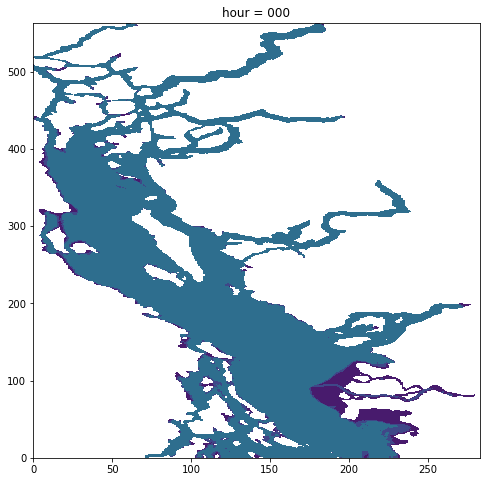

In [10]:
def animate_one_density2(file1, rho):
    depth = file1.variables['deptht'][:]
    saline1 = file1.variables['vosaline'][:]
    temp1 = file1.variables['votemper'][:]
    a = np.expand_dims(depth, 1).T
    b = np.expand_dims(np.expand_dims(a,2), 3)
    c = np.ones((155,40,564, 284)) * b
    density1 = calc_rho(saline1, temp1, c)
    diff1 = np.abs(density1 - rho)
    diff1[diff1 > 2] = 100000 
    index1 = diff1.argmin(axis=1)
    list_of_depths1 = np.zeros((155,564,284))
    for t in range(155):
        for y in range(564):
            for x in range(284):
                list_of_depths1[t,y,x] = depth[index1[t,y,x]]
    mask_land = 1 - new_domain[0,:,:]
    fig,ax = plt.subplots(figsize=(8,8))
    def animate30(i):
        ax.clear()
        masked_depths1 = ma.masked_array(list_of_depths1[i,:,:], mask = mask_land)
        ax.contourf(masked_depths1, 
                      levels = np.linspace(0, 70, 8))
        ax.set_title('hour = %03d'%(i)) 
        return ax

    interval = 0.25#in seconds
    ani40 = animation.FuncAnimation(fig,animate30,frames=155,interval=interval*1e+3, repeat=False)
    return ani40

animate_one_density2(NU0, 1023.3)

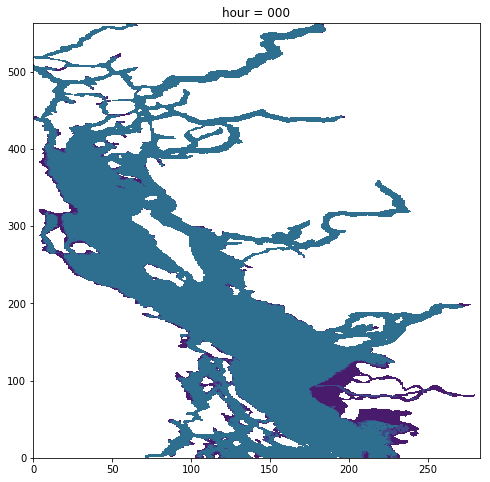

In [30]:
def animate_one_density2(file1, rho):
    depth = file1.variables['deptht'][:]
    saline1 = file1.variables['vosaline'][:]
    temp1 = file1.variables['votemper'][:]
    a = np.expand_dims(depth, 1).T
    b = np.expand_dims(np.expand_dims(a,2), 3)
    c = np.ones((155,40,564, 284)) * b
    density1 = calc_rho(saline1, temp1, c)
    diff1 = np.abs(density1 - rho)
    #diff1[diff1 > 0.5] = 10000000 
    index1 = diff1.argmin(axis=1)
    list_of_depths1 = np.zeros((155,564,284))
    for t in range(155):
        for y in range(564):
            for x in range(284):
                list_of_depths1[t,y,x] = depth[index1[t,y,x]]
    mask_land = 1 - new_domain[0,:,:]
    fig,ax = plt.subplots(figsize=(8,8))
    def animate30(i):
        ax.clear()
        masked_depths1 = ma.masked_array(list_of_depths1[i,:,:], mask = mask_land)
        ax.contourf(masked_depths1, 
                      levels = np.linspace(0, 70, 8))
        ax.set_title('hour = %03d'%(i)) 
        return ax

    interval = 0.25#in seconds
    ani40 = animation.FuncAnimation(fig,animate30,frames=155,interval=interval*1e+3, repeat=False)
    return ani40

animate_one_density2(NU0, 1023.3)

In [49]:
b = np.random.rand(2,3,4)

In [62]:
b

array([[[ 0.83252747,  0.16347018,  0.20688075,  0.26925324],
        [ 0.95609503,  0.85823539,  0.50408522,  0.20254944],
        [ 0.69492897,  0.33615279,  0.3607002 ,  0.15021336]],

       [[ 0.39834211,  0.59381731,  0.65623484,  0.66642096],
        [ 0.89125279,  0.85336464,  0.44754848,  0.82161914],
        [ 0.05045952,  0.27992178,  0.19209011,  0.77183403]]])

In [63]:
c = np.ones((1,3,4), dtype=int)

In [64]:
c

array([[[1, 1, 1, 1],
        [1, 1, 1, 1],
        [1, 1, 1, 1]]])

In [66]:
b[c].shape

(1, 3, 4, 3, 4)

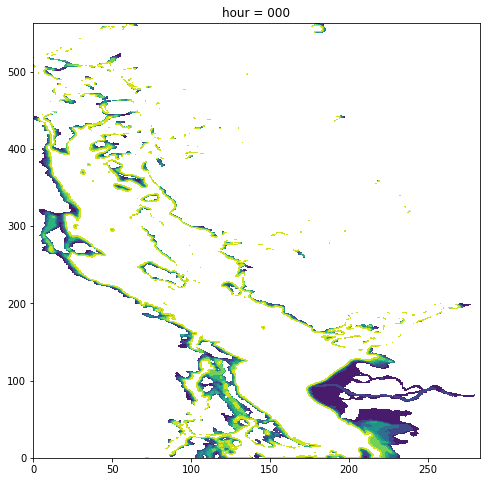

In [12]:
def animate_one_density2(file1, rho):
    depth = file1.variables['deptht'][:]
    saline1 = file1.variables['vosaline'][:]
    temp1 = file1.variables['votemper'][:]
    a = np.expand_dims(depth, 1).T
    b = np.expand_dims(np.expand_dims(a,2), 3)
    c = np.ones((155,40,564, 284)) * b
    density1 = calc_rho(saline1, temp1, c)
    diff1 = np.abs(density1 - rho)
    diff1[diff1 > 2] = 0.01
    index1 = diff1.argmin(axis=1)
    list_of_depths1 = np.zeros((155,564,284))
    for t in range(155):
        for y in range(564):
            for x in range(284):
                list_of_depths1[t,y,x] = depth[index1[t,y,x]]
    mask_land = 1 - new_domain[0,:,:]
    fig,ax = plt.subplots(figsize=(8,8))
    def animate30(i):
        ax.clear()
        masked_depths1 = ma.masked_array(list_of_depths1[i,:,:], mask = mask_land)
        ax.contourf(masked_depths1, 
                      levels = np.linspace(0, 70, 8))
        ax.set_title('hour = %03d'%(i)) 
        return ax

    interval = 0.25#in seconds
    ani40 = animation.FuncAnimation(fig,animate30,frames=155,interval=interval*1e+3, repeat=False)
    return ani40

animate_one_density2(NU0, 1023.3)

In [27]:
a=np.array([5,1,2,3,np.NaN])

In [28]:
a

array([  5.,   1.,   2.,   3.,  nan])

In [29]:
a.argmin()

4

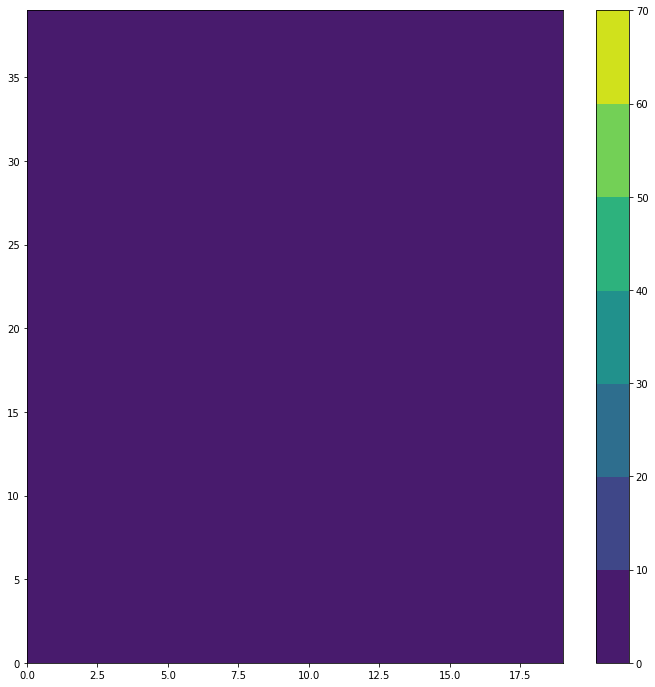

In [19]:
fig,ax = plt.subplots(figsize=(12,12))
#masked_depths1 = ma.masked_array(list_of_depths1[70,:,:], mask = mask_land)
den = ax.contourf(np.ones((40,20)), levels = np.linspace(0, 70, 8))
fig.colorbar(den, ax=ax)

# Wind Event

* pre winds: 6 hours
* ramp up: 45 hours
* sustained: 10 hours
* ramp down: 75 hours
* post winds: 24 hours

### Winds from the south, uniform v winds, vtau = 0.4, winter stratification

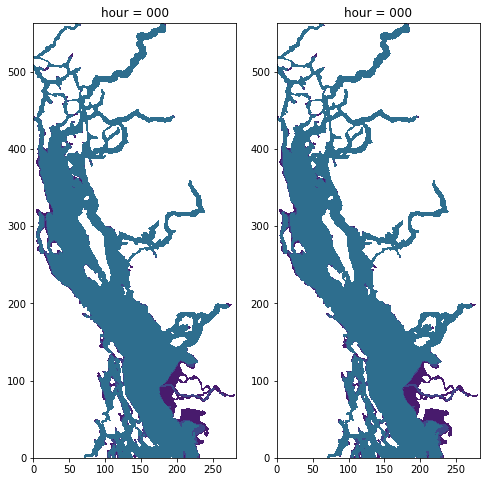

In [6]:
animate_one_density(NU0,NU02,1023.3)

### Varying V winds from the south, vtau = 0.4 at y = 564, vtau = ~0 at y = 0, winter stratification 

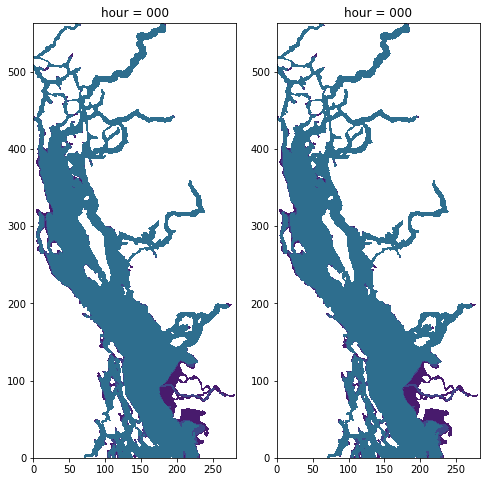

In [7]:
animate_one_density(NG0,NG02,1023.3)

### Varying V winds from the south, vtau = 0.4 at y = 564, vtau = 0.1 at y = 0, winter stratification

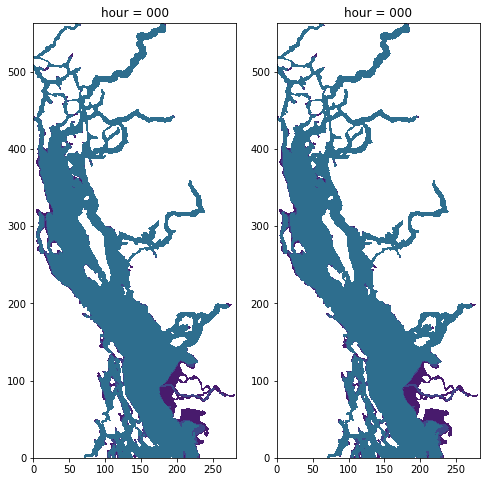

In [8]:
animate_one_density(NS0,NS02,1023.3)

In [9]:
SU0 =nc.Dataset('/ocean/vdo/MEOPAR/completed-runs/SalishSeaLake/SU0/SalishSea_1h_20160601_20160607_grid_T.nc')
SU02 = nc.Dataset('/ocean/vdo/MEOPAR/completed-runs/SalishSeaLake/SU0.2/SalishSea_1h_20160601_20160607_grid_T.nc')
SG0 = nc.Dataset('/ocean/vdo/MEOPAR/completed-runs/SalishSeaLake/SG0/SalishSea_1h_20160601_20160607_grid_T.nc')
SG02 = nc.Dataset('/ocean/vdo/MEOPAR/completed-runs/SalishSeaLake/SG0.2/SalishSea_1h_20160601_20160607_grid_T.nc')
SS0 = nc.Dataset('/ocean/vdo/MEOPAR/completed-runs/SalishSeaLake/SS0/SalishSea_1h_20160601_20160607_grid_T.nc')
SS02 = nc.Dataset('/ocean/vdo/MEOPAR/completed-runs/SalishSeaLake/SS0.2/SalishSea_1h_20160601_20160607_grid_T.nc')

### uniform V winds from the north, vtau = 0.4, summer stratification

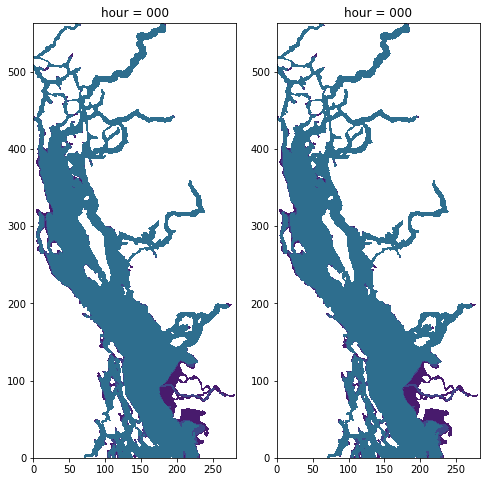

In [10]:
animate_one_density(SU0,SU02,1023.3)

### Varying V winds from the north, vtau = 0.4 at y = 564, vtau = ~0 at y = 0, summer stratification

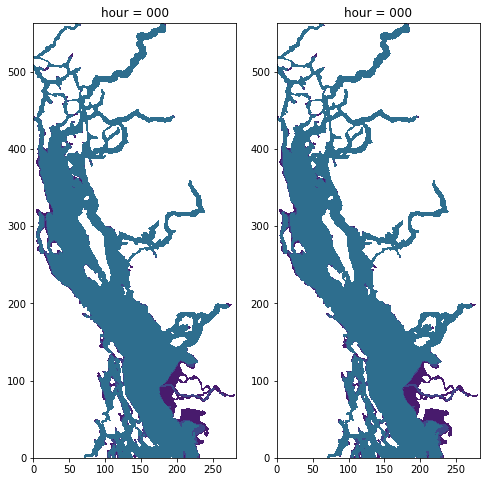

In [11]:
animate_one_density(SG0,SG02,1023.3)

### Varying V winds from the north, vtau = 0.4 at y = 564, vtau = 0.1 at y = 0, summer stratification

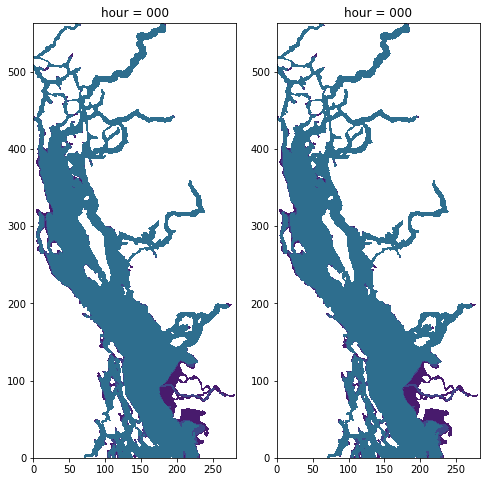

In [12]:
animate_one_density(SS0,SS02,1023.3)

In [15]:
C0 =nc.Dataset('/ocean/vdo/MEOPAR/completed-runs/SalishSeaLake/C0/SalishSea_1h_20170101_20170107_grid_T.nc')
C02 = nc.Dataset('/ocean/vdo/MEOPAR/completed-runs/SalishSeaLake/C0.2/SalishSea_1h_20170101_20170107_grid_T.nc')
D0 = nc.Dataset('/ocean/vdo/MEOPAR/completed-runs/SalishSeaLake/D0/SalishSea_1h_20170101_20170107_grid_T.nc')
D02 = nc.Dataset('/ocean/vdo/MEOPAR/completed-runs/SalishSeaLake/D0.2/SalishSea_1h_20170101_20170107_grid_T.nc')

### Converging V winds, max vtau = 0.4, centered at y = 240, winter stratification

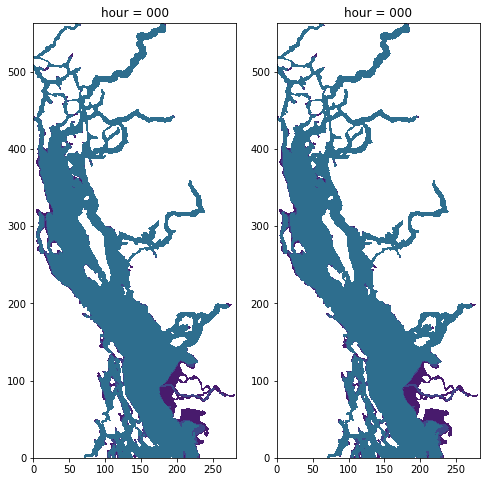

In [16]:
animate_one_density(C0,C02,1023.3)

### Diverging V winds, max vtau = 0.4, centered at y = 240, winter stratification

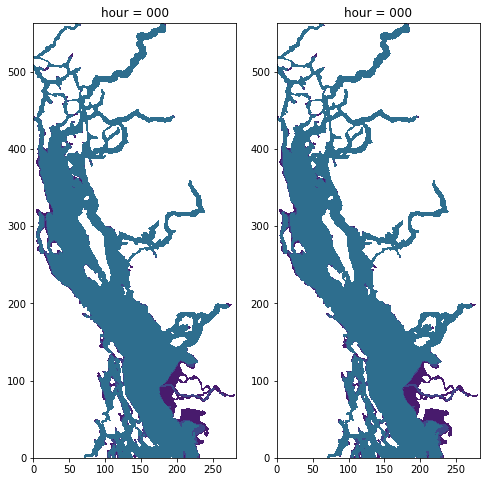

In [17]:
animate_one_density(D0,D02,1023.3)